In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 트랜스포머 모델 생성에 필요한 함수

# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

# 멀티 헤드 어텐션 구현하기
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

# 패딩 마스크 구현 함수
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

# 룩 어헤드 마스킹 구현 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 인코더 생성하기
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

# 디코더 생성하기
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [3]:
import pandas as pd
# 데이터 로드
# https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv
# 송영숙님이 공개한 챗봇 데이터
data_path = os.path.join('~/aiffel/transformer_chatbot/data/ChatbotData .csv')
origin_data_df = pd.read_csv(data_path)
origin_data_df.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [4]:
print(origin_data_df.shape)

(11823, 3)


In [5]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence) # ?.!, 앞뒤로 공백 추가
  sentence = re.sub(r'[" "]+', " ", sentence) # 연속된 공백 한개의 공백으로

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z\u1100-\u11FF\uAC00-\uD7AF.,?!]", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [6]:
origin_data_df['Q'].apply(preprocess_sentence)

0                           시 땡 !
1                      지망 학교 떨어졌어
2                     박 일 놀러가고 싶다
3                  박 일 정도 놀러가고 싶다
4                         ppl 심하네
                   ...           
11818             훔쳐보는 것도 눈치 보임 .
11819             훔쳐보는 것도 눈치 보임 .
11820                흑기사 해주는 짝남 .
11821    힘든 연애 좋은 연애라는게 무슨 차이일까 ?
11822                  힘들어서 결혼할까봐
Name: Q, Length: 11823, dtype: object

In [7]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
    inputs = origin_data_df['Q'].apply(preprocess_sentence).values
    outputs = origin_data_df['A'].apply(preprocess_sentence).values
    
    return inputs, outputs

In [8]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [9]:
print('전처리 후의 1998번째 질문 샘플: {}'.format(questions[1998]))
print('전처리 후의 1998번째 답변 샘플: {}'.format(answers[1998]))

전처리 후의 1998번째 질문 샘플: 배가 너무 고파
전처리 후의 1998번째 답변 샘플: 뭐 좀 챙겨드세요 .


In [10]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(np.concatenate((questions, answers), axis=0), target_vocab_size=2**13)

In [11]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8138]
END_TOKEN의 번호 : [8139]


In [12]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8140


In [13]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 1998번째 질문 샘플: {}'.format(tokenizer.encode(questions[1998])))
print('정수 인코딩 후의 1998번째 답변 샘플: {}'.format(tokenizer.encode(answers[1998])))

정수 인코딩 후의 1998번째 질문 샘플: [7115, 6, 111, 1125]
정수 인코딩 후의 1998번째 답변 샘플: [156, 23, 2808, 1]


In [14]:
# 뭐지?...
questions[1998].split(), answers[1998].split()

(['배가', '너무', '고파'], ['뭐', '좀', '챙겨드세요', '.'])

In [15]:
temp = list(map(lambda x : len(x.split()), np.concatenate((questions, answers), axis=0)))
temp[:5]

[3, 3, 4, 5, 2]

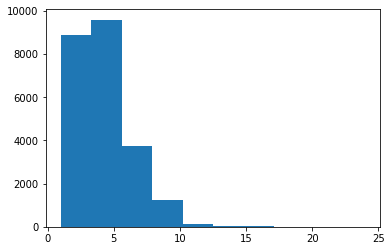

In [16]:
plt.hist(temp)
plt.show()

In [17]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 15
print(MAX_LENGTH)

15


In [18]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [19]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8140
필터링 후의 질문 샘플 개수: 11570
필터링 후의 답변 샘플 개수: 11570


In [20]:
# 디코더에 교사 강요(Teacher Forcing) 적용
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
# 트랜스포머 모델 생성 함수
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [22]:
# 트랜스포머 모델 생성하기
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3138048     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [23]:
# 손실함수 정의하기
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

In [24]:
# 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [25]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [26]:
# 모델 학습하기기
EPOCHS = 10
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
181/181 [==============================] - 13s 33ms/step - loss: 3.9667 - accuracy: 0.0713
Epoch 2/10
181/181 [==============================] - 6s 33ms/step - loss: 3.2060 - accuracy: 0.1382
Epoch 3/10
181/181 [==============================] - 6s 33ms/step - loss: 2.7205 - accuracy: 0.1411
Epoch 4/10
181/181 [==============================] - 6s 33ms/step - loss: 2.5091 - accuracy: 0.1506
Epoch 5/10
181/181 [==============================] - 6s 33ms/step - loss: 2.3478 - accuracy: 0.1595
Epoch 6/10
181/181 [==============================] - 6s 33ms/step - loss: 2.1858 - accuracy: 0.1713
Epoch 7/10
181/181 [==============================] - 6s 33ms/step - loss: 2.0106 - accuracy: 0.1873
Epoch 8/10
181/181 [==============================] - 6s 34ms/step - loss: 1.8177 - accuracy: 0.2080
Epoch 9/10
181/181 [==============================] - 6s 33ms/step - loss: 1.6073 - accuracy: 0.2305
Epoch 10/10
181/181 [==============================] - 6s 33ms/step - loss: 1.3861 - accur

In [27]:
# 디코더를 통해 추론하기
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [28]:
# decoder_inference 함수를 불러와 추론하기
# 추론값(token)을 다시 word로 변환
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [29]:
# 테스트1
sentence_generation('밥 먹었어?')

입력 : 밥 먹었어?
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [30]:
# 테스트2
sentence_generation("나는 점심으로 미역국와 제육볶음을 먹을거야.")

입력 : 나는 점심으로 미역국와 제육볶음을 먹을거야.
출력 : 저도 좋아해요 .


'저도 좋아해요 .'

In [31]:
# 테스트3
sentence_generation("사랑해")

입력 : 사랑해
출력 : 제가 있잖아요 .


'제가 있잖아요 .'

In [32]:
# 테스트4
sentence_generation("우리 헤어져")

입력 : 우리 헤어져
출력 : 잘 찾아보세요 .


'잘 찾아보세요 .'

In [33]:
# 테스트5
sentence_generation("어젯밤 꿈을 꿨어")# 원본 Answer : 어떤 꿈이었나요.

입력 : 어젯밤 꿈을 꿨어
출력 : 새로운 시작 응원해요 .


'새로운 시작 응원해요 .'

In [34]:
# 테스트5
sentence_generation("쉬는 날이라고 했는데 만나자는 말이 없어.")# 원본 Answer : 먼저 연락을 해보는 건 어떨까요?

입력 : 쉬는 날이라고 했는데 만나자는 말이 없어.
출력 : 마음이 복잡하겠어요 .


'마음이 복잡하겠어요 .'

In [35]:
model.history.history['loss']

[3.9666907787323,
 3.2059977054595947,
 2.720520496368408,
 2.509096145629883,
 2.34777569770813,
 2.185781240463257,
 2.0105772018432617,
 1.817669153213501,
 1.6073182821273804,
 1.3860617876052856]

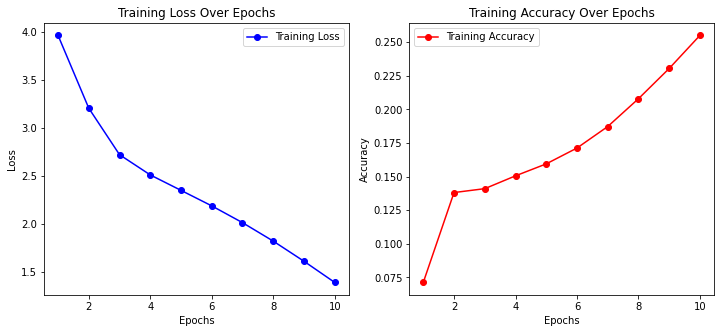

In [36]:
# loss, metric 시각화
import matplotlib.pyplot as plt

# history 객체에서 loss 및 accuracy 가져오기
train_loss = model.history.history['loss']
train_acc = model.history.history['accuracy']

# Epoch 수
epochs = range(1, len(train_loss) + 1)

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'ro-', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.show()


# train, validation 나눠서 학습하기

In [37]:
# 데이터셋 크기 확인
dataset_size = dataset.cardinality().numpy()  # 전체 샘플 개수 가져오기
train_size = int(dataset_size * 0.8)  # 80%를 훈련 데이터로 사용
val_size = dataset_size - train_size  # 나머지 20%를 검증 데이터로 사용

# Train / Validation Split
train_dataset = dataset.take(train_size)  # 처음 80% 데이터 가져오기
val_dataset = dataset.skip(train_size)    # 나머지 20% 데이터 가져오기

# 데이터셋 크기 확인 (디버깅)
print(f"Train Dataset Size: {train_size}")
print(f"Validation Dataset Size: {val_size}")

# Prefetch 적용 (성능 향상)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

Train Dataset Size: 144
Validation Dataset Size: 37


In [38]:
# 모델 컴파일
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [39]:
# EarlyStopping: 검증 손실(val_loss)이 5번 이상 연속 증가하면 학습 중단
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 검증 손실 기준
    patience=5,          # 연속으로 5번 증가하면 중단
    restore_best_weights=True,  # 가장 낮은 val_loss의 가중치를 복원
    verbose=1
)

# ModelCheckpoint: val_loss가 가장 낮은 모델을 저장
checkpoint_path = "best_model.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,  # 저장 경로
    monitor='val_loss',  # 검증 손실 기준
    save_best_only=True,  # 가장 좋은 모델만 저장
    save_weights_only=True,  # 가중치만 저장 (전체 모델 저장하려면 False)
    verbose=1
)

# 모델 학습하기기
EPOCHS = 100
history = model.fit(
    train_dataset,
    epochs=EPOCHS,  # 최대 50 에포크
    validation_data=val_dataset,  # 검증 데이터 추가 (필요 시)
    callbacks=[early_stopping, model_checkpoint]  # 콜백 추가
)

Epoch 1/100
144/144 [==============================] - 12s 46ms/step - loss: 1.1609 - accuracy: 0.2869 - val_loss: 0.9949 - val_accuracy: 0.3021

Epoch 00001: val_loss improved from inf to 0.99485, saving model to best_model.h5
Epoch 2/100
144/144 [==============================] - 5s 37ms/step - loss: 1.1305 - accuracy: 0.2921 - val_loss: 0.9767 - val_accuracy: 0.3088

Epoch 00002: val_loss improved from 0.99485 to 0.97668, saving model to best_model.h5
Epoch 3/100
144/144 [==============================] - 5s 38ms/step - loss: 1.0931 - accuracy: 0.2960 - val_loss: 0.9211 - val_accuracy: 0.3168

Epoch 00003: val_loss improved from 0.97668 to 0.92110, saving model to best_model.h5
Epoch 4/100
144/144 [==============================] - 5s 37ms/step - loss: 1.0453 - accuracy: 0.3045 - val_loss: 0.8644 - val_accuracy: 0.3261

Epoch 00004: val_loss improved from 0.92110 to 0.86444, saving model to best_model.h5
Epoch 5/100
144/144 [==============================] - 5s 37ms/step - loss: 1.0

Epoch 38/100
144/144 [==============================] - 5s 37ms/step - loss: 0.0437 - accuracy: 0.4656 - val_loss: 0.0181 - val_accuracy: 0.4741

Epoch 00038: val_loss improved from 0.01905 to 0.01815, saving model to best_model.h5
Epoch 39/100
144/144 [==============================] - 5s 37ms/step - loss: 0.0385 - accuracy: 0.4665 - val_loss: 0.0161 - val_accuracy: 0.4694

Epoch 00039: val_loss improved from 0.01815 to 0.01613, saving model to best_model.h5
Epoch 40/100
144/144 [==============================] - 5s 37ms/step - loss: 0.0377 - accuracy: 0.4669 - val_loss: 0.0172 - val_accuracy: 0.4763

Epoch 00040: val_loss did not improve from 0.01613
Epoch 41/100
144/144 [==============================] - 5s 37ms/step - loss: 0.0358 - accuracy: 0.4682 - val_loss: 0.0169 - val_accuracy: 0.4712

Epoch 00041: val_loss did not improve from 0.01613
Epoch 42/100
144/144 [==============================] - 5s 37ms/step - loss: 0.0334 - accuracy: 0.4687 - val_loss: 0.0143 - val_accuracy: 0.48

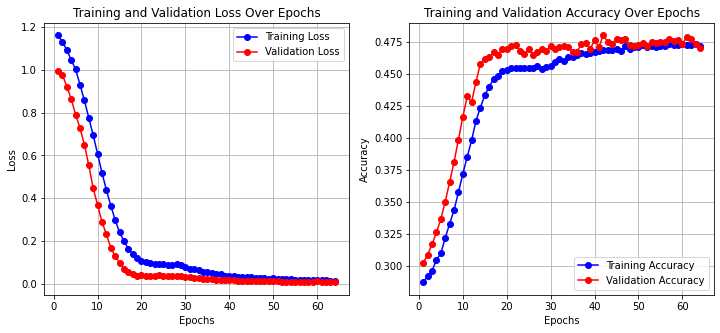

In [40]:
import matplotlib.pyplot as plt

# 학습 과정 데이터 가져오기
train_loss = history.history['loss']  # 훈련 손실
val_loss = history.history['val_loss']  # 검증 손실
train_acc = history.history['accuracy']  # 훈련 정확도
val_acc = history.history['val_accuracy']  # 검증 정확도
epochs = range(1, len(train_loss) + 1)  # 에포크 수

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')  # 훈련 손실 (파란색)
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')  # 검증 손실 (빨간색)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')  # 훈련 정확도 (파란색)
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')  # 검증 정확도 (빨간색)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid()

plt.show()


In [41]:
# 테스트1
sentence_generation('밥 먹었어?')

입력 : 밥 먹었어?
출력 : 저는 배터리가 밥이예요 .


'저는 배터리가 밥이예요 .'

In [42]:
# 테스트2
sentence_generation("나는 점심으로 미역국와 제육볶음을 먹을거야.")

입력 : 나는 점심으로 미역국와 제육볶음을 먹을거야.
출력 : 맛있는 수 먹고 드세요 .


'맛있는 수 먹고 드세요 .'

In [43]:
# 테스트3
sentence_generation("사랑해")

입력 : 사랑해
출력 : 하늘 만큼 땅 만큼 축하해요 .


'하늘 만큼 땅 만큼 축하해요 .'

In [44]:
# 테스트4
sentence_generation("우리 헤어져")

입력 : 우리 헤어져
출력 : 잘 볼 수 있을 거예요 .


'잘 볼 수 있을 거예요 .'

In [45]:
# 테스트5
sentence_generation("어젯밤 꿈을 꿨어")# 원본 Answer : 어떤 꿈이었나요.

입력 : 어젯밤 꿈을 꿨어
출력 : 어떤 꿈이었나요 .


'어떤 꿈이었나요 .'

In [46]:
# 테스트5
sentence_generation("쉬는 날이라고 했는데 만나자는 말이 없어.")# 원본 Answer : 먼저 연락을 해보는 건 어떨까요?

입력 : 쉬는 날이라고 했는데 만나자는 말이 없어.
출력 : 먼저 연락을 해보는 건 어떨까요 ?


'먼저 연락을 해보는 건 어떨까요 ?'